In [1]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes
from data_fetching import fetch_inmet_data

In [28]:
import pandas as pd
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt
import basedosdados as bd
import geopandas as gpd
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
from shapely.ops import unary_union
import rasterio

# Temperatura ao decorrer dos anos

In [3]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

In [4]:
all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

In [5]:
combined_data.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_max,...,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,data,id_estacao,ano
0,6,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.770016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-09,A305,2003
1,6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.765882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-24,A305,2003
2,6,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.936176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-26,A305,2003
3,6,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.956425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-29,A305,2003
4,6,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.956425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-29,A305,2003


In [6]:
combined_data['id_estacao'].unique()

array(['A305', 'A306', 'A307', 'A308', 'A408', 'A412', 'A310', 'A309',
       'A313', 'A526', 'A539', 'A543', 'A314', 'A315', 'A316', 'A317',
       'A318', 'A319', 'A321', 'A322', 'A323', 'A324', 'A325', 'A327',
       'A329', 'A330', 'A331', 'A332', 'A333', 'A334', 'A336', 'A337',
       'A339', 'A340', 'A413', 'A415', 'A416', 'A417', 'A418', 'A419',
       'A420', 'A423', 'A424', 'A425', 'A426', 'A428', 'A429', 'A430',
       'A432', 'A433', 'A435', 'A436', 'A439', 'A440', 'A441', 'A442',
       'A443', 'A342', 'A349', 'A343', 'A328', 'A345', 'A347', 'A348',
       'A350', 'A351', 'A354', 'A358', 'A359', 'A360', 'A365', 'A366',
       'A367', 'A448', 'A450', 'A559', 'A563', 'A449', 'A454', 'A451',
       'A453', 'A370', 'A371', 'A372', 'A373', 'A368', 'A369', 'A458'],
      dtype=object)

In [7]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['data', 'temperatura_max', 'temperatura_min', 'ano']]

# Agrupar por ano
temperatura_anual = temperaturas.groupby('ano').agg({
    'temperatura_max': 'max',
    'temperatura_min': 'min'
}).reset_index()

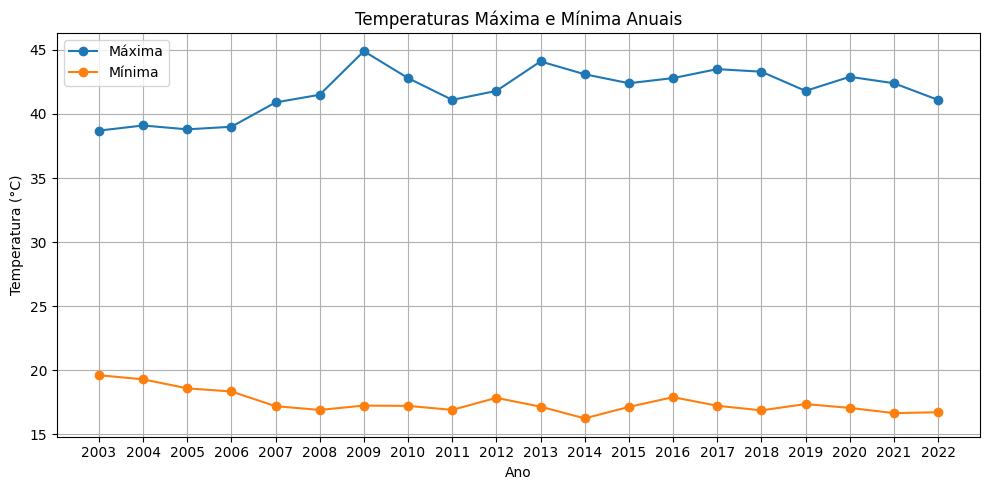

In [9]:
# Visualizar a série temporal
# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais')
plt.xticks(range(2003, 2023))  # Define os ticks do eixo x para cada ano de 2003 a 2022
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço ao conteúdo
plt.show()

# Segmentações ao decorrer dos anos

In [ ]:
# Diretório onde os arquivos serão salvos
save_dir = '../dados/segmentacoes'

# Lista de anos
years = range(2003, 2022)  

# Loop para baixar os arquivos
for year in years:
    # Construindo a URL para o ano atual
    url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_{year}.tif'
    
    # Nome do arquivo local onde o TIF será salvo
    local_filename = f'{save_dir}brasil_coverage_{year}.tif'

    # Fazendo a requisição para baixar o arquivo
    response = requests.get(url)
    
    # Verificando se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Garantindo que o diretório exista
        os.makedirs(save_dir, exist_ok=True)
        
        # Escrevendo o conteúdo do arquivo baixado no arquivo local
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
    else:
        print(f'Falha ao baixar o arquivo para o ano {year}.')

Arquivo ../dados/segmentacoesbrasil_coverage_2000.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2001.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2002.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2003.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2004.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2005.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2006.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2007.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2008.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2009.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2010.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2011.tif baixado e salvo com sucesso.
Arqu

## Agora precisamos delimitar pelas estações na região da caatinga

In [10]:
# Caminho para o shapefile dos biomas
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'

# Carregar o shapefile dos biomas
biomes = gpd.read_file(biomes_shp)

# Filtrar para obter apenas a Caatinga
caatinga = biomes[biomes['Bioma'] == 'Caatinga']

# Para carregar o dado direto no pandas
df_estacoes = bd.read_table(dataset_id='br_inmet_bdmep',
table_id='estacao',
billing_project_id="projetopdi-430718")

# Convertendo o DataFrame em GeoDataFrame
gdf_estacoes = gpd.GeoDataFrame(
    df_estacoes, 
    geometry=gpd.points_from_xy(df_estacoes['longitude'], df_estacoes['latitude']),
    crs="EPSG:4674"
)

# Reprojetar o GeoDataFrame das estações para o mesmo CRS que o shapefile dos biomas
gdf_estacoes = gdf_estacoes.to_crs(caatinga.crs)

# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

Downloading: 100%|██████████| 612/612 [00:00<00:00, 1247.99rows/s]


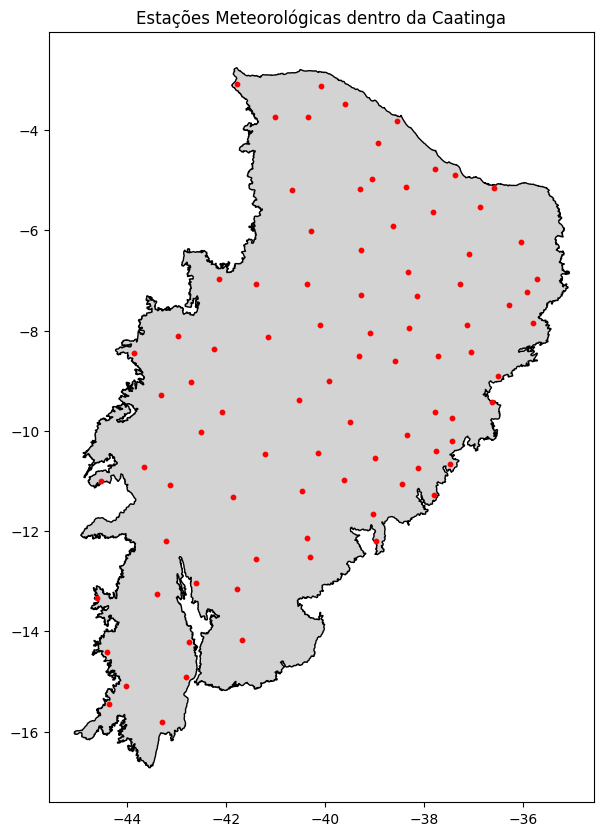

In [11]:
# Plotar um mapa com as estações
fig, ax = plt.subplots(figsize=(10, 10))
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)
plt.title('Estações Meteorológicas dentro da Caatinga')
plt.show()

Precisamos dividir o mapa de acordo com as estações

In [12]:
# Filtrar as estações que estão dentro da Caatinga
stations_within_caatinga = gdf_estacoes[gdf_estacoes.geometry.within(caatinga.unary_union)]

# Extrair as coordenadas das estações
coords = np.array(list(zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y)))

# Adicionar pontos fictícios ao redor do perímetro da Caatinga
minx, miny, maxx, maxy = caatinga.total_bounds
padding = 0.5  # Ajuste conforme necessário
extra_points = [
    [minx - padding, miny - padding],
    [minx - padding, maxy + padding],
    [maxx + padding, miny - padding],
    [maxx + padding, maxy + padding]
]

# Adicionar os novos pontos às coordenadas das estações
all_points = np.vstack([coords, extra_points])

# Gerar os polígonos de Voronoi com os pontos adicionais
vor = Voronoi(all_points)

# Criar polígonos de Voronoi a partir dos vértices
polygons = []
for region in vor.regions:
    if not -1 in region and region:
        polygon = Polygon([vor.vertices[i] for i in region])
        polygons.append(polygon)

# Criar um GeoDataFrame com os polígonos de Voronoi
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=stations_within_caatinga.crs)

# Verificar e corrigir geometrias inválidas antes do clipping
gdf_voronoi['geometry'] = gdf_voronoi['geometry'].buffer(0)

# Clipping com o polígono da Caatinga para garantir que todos os polígonos estejam dentro da região
gdf_voronoi_clipped = gpd.GeoDataFrame(
    geometry=[poly.intersection(caatinga.unary_union) for poly in gdf_voronoi.geometry if not poly.is_empty],
    crs=gdf_voronoi.crs
)

# Remover geometrias vazias
gdf_voronoi_clipped = gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]


### Carregar e Filtrar Estações na Caatinga

- **`gdf_estacoes.geometry.within(caatinga.unary_union)`**: Verifica se cada ponto (estação meteorológica) está dentro do polígono da Caatinga. `unary_union` combina todos os polígonos em `caatinga` em um único polígono.
- **`stations_within_caatinga`**: Filtra o `GeoDataFrame` `gdf_estacoes` para manter apenas as estações que estão dentro dos limites do bioma Caatinga.

### Extrair Coordenadas das Estações

- **`stations_within_caatinga.geometry.x`** e **`stations_within_caatinga.geometry.y`**: Extrai as coordenadas X (longitude) e Y (latitude) das estações.
- **`zip(...)`**: Combina as coordenadas X e Y em pares (longitude, latitude).
- **`list(...)`**: Converte o objeto `zip` em uma lista de tuplas.
- **`np.array(...)`**: Converte a lista de tuplas em um array NumPy para facilitar o uso posterior.

### Adicionar Pontos Fictícios ao Perímetro da Caatinga

- **`caatinga.total_bounds`**: Calcula os limites do polígono da Caatinga, retornando as coordenadas mínimas e máximas (minx, miny, maxx, maxy) que formam um retângulo ao redor do bioma.

- **`padding = 0.5`**: Define um valor de preenchimento para adicionar aos limites, de modo que os pontos fictícios fiquem um pouco fora do perímetro exato da Caatinga.

- **`extra_points`**: Define quatro pontos fictícios ao redor do retângulo que circunda a Caatinga. Esses pontos ajudam a garantir que os polígonos de Voronoi sejam corretamente gerados para cobrir toda a área da Caatinga.

### Combinar Pontos Fictícios e Coordenadas das Estações

- **`np.vstack([...])`**: Combina as coordenadas das estações meteorológicas e os pontos fictícios em um único array 2D. `vstack` empilha verticalmente os arrays.

### Gerar Polígonos de Voronoi

- **`Voronoi(all_points)`**: Gera a diagrama de Voronoi com base em todos os pontos (estações + pontos fictícios). O Voronoi divide o espaço em regiões, onde cada região contém todos os pontos mais próximos de uma determinada estação.

- **`for region in vor.regions:`**: Itera por todas as regiões do diagrama de Voronoi.
- **`if not -1 in region and region:`**: Verifica se a região é válida (não contém -1 e não está vazia).
- **`Polygon([...])`**: Cria um polígono para cada região, usando os vértices da região.
- **`polygons.append(polygon)`**: Adiciona o polígono à lista `polygons`.

### Criar um GeoDataFrame com os Polígonos de Voronoi

- **`gpd.GeoDataFrame(...)`**: Cria um novo `GeoDataFrame` com os polígonos de Voronoi. A projeção (CRS) é definida para ser a mesma das estações meteorológicas (`stations_within_caatinga.crs`).

### Verificar e Corrigir Geometrias Inválidas

- **`buffer(0)`**: Aplica um buffer com valor zero para cada polígono, o que é uma técnica comum para corrigir geometrias inválidas em shapefiles.

### Clipping com a Caatinga

- **`poly.intersection(caatinga.unary_union)`**: Recorta cada polígono de Voronoi para que ele caiba dentro do limite da Caatinga.
- **`if not poly.is_empty`**: Garante que apenas polígonos não vazios sejam considerados.
- **`gpd.GeoDataFrame(...)`**: Cria um novo `GeoDataFrame` contendo apenas os polígonos recortados.

### Remover Geometrias Vazias

- **`gdf_voronoi_clipped[~gdf_voronoi_clipped.is_empty]`**: Filtra o `GeoDataFrame` para remover qualquer polígono que esteja vazio.


In [ ]:
# Associar o polígono ao ID da estação mais próxima
def find_nearest_station(polygon, stations):
    centroid = polygon.centroid
    distances = stations.geometry.apply(lambda x: centroid.distance(x))
    nearest_station = stations.loc[distances.idxmin()]
    return nearest_station['id_estacao']

gdf_voronoi_clipped['id_estacao'] = gdf_voronoi_clipped.geometry.apply(lambda poly: find_nearest_station(poly, stations_within_caatinga))

### Associar Polígonos às Estações Meteorológicas

- **`polygon.centroid`**: Calcula o centróide (ponto médio) de um polígono.
- **`stations.geometry.apply(lambda x: centroid.distance(x))`**: Calcula a distância do centróide até todas as estações meteorológicas.
- **`stations.loc[distances.idxmin()]`**: Encontra a estação com a menor distância até o centróide.
- **`return nearest_station['id_estacao']`**: Retorna o ID da estação mais próxima.
- **`gdf_voronoi_clipped['id_estacao']`**: Cria uma nova coluna no `GeoDataFrame` com o ID da estação mais próxima para cada polígono.

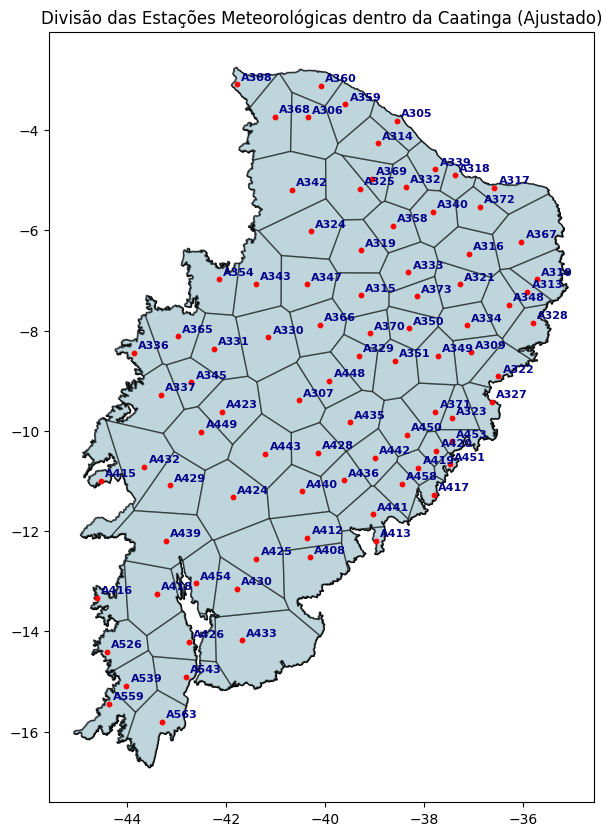

In [13]:
# Plotar o resultado ajustado
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o perímetro da Caatinga
caatinga.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plotar os polígonos de Voronoi
gdf_voronoi_clipped.plot(ax=ax, edgecolor='black', color='lightblue', alpha=0.5)

# Plotar as estações meteorológicas
stations_within_caatinga.plot(ax=ax, color='red', markersize=10)

# Adicionar o ID das estações no plot
for x, y, label in zip(stations_within_caatinga.geometry.x, stations_within_caatinga.geometry.y, stations_within_caatinga['id_estacao']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='darkblue', weight='bold')

plt.title('Divisão das Estações Meteorológicas dentro da Caatinga (Ajustado)')
plt.show()

# Salvar o shapefile resultante
gdf_voronoi_clipped.to_file('../dados/shapefile_estacoes_divididas/estacoes_territorios_dividido.shp')

In [19]:
def process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped):
    """
    Processa todos os arquivos GeoTIFF na pasta segmentacoes para todas as estações,
    salvando os resultados em pastas separadas por ano.

    Args:
    segmentacoes_dir (str): Caminho para a pasta contendo os arquivos GeoTIFF de entrada.
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes serão salvos.
    gdf_voronoi_clipped (GeoDataFrame): GeoDataFrame contendo os polígonos de Voronoi.
    """

    # Listar todos os arquivos GeoTIFF na pasta segmentacoes
    tiff_files = glob.glob(os.path.join(segmentacoes_dir, '*.tif'))

    # Obter os IDs únicos das estações
    estacao_ids = gdf_voronoi_clipped['id_estacao'].unique()

    for tiff_file in tiff_files:
        # Extrair o ano do nome do arquivo GeoTIFF
        year = os.path.basename(tiff_file).split('_')[-1].split('.')[0]

        # Criar diretório para o ano se não existir
        year_dir = os.path.join(output_base_dir, year)
        os.makedirs(year_dir, exist_ok=True)

        for estacao_id in estacao_ids:
            # Aplicar a função para salvar o TIFF mascarado
            save_masked_tiff(tiff_file, estacao_id, year_dir, gdf_voronoi_clipped)
            print(f"Salvo: {year_dir}/coverage_{estacao_id}_{year}.tif")


# Definir caminhos
segmentacoes_dir = '../dados/segmentacoes'
output_base_dir = '../dados/raster_tiff_caating'

# Executar o processamento para todos os arquivos e estações
process_all_tiffs(segmentacoes_dir, output_base_dir, gdf_voronoi_clipped)

Salvo: ../dados/raster_tiff_caating\2003/coverage_A336_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A365_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A416_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A433_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A308_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A368_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A539_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A543_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A526_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A559_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A563_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A454_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A418_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A426_2003.tif
Salvo: ../dados/raster_tiff_caating\2003/coverage_A430_2003.tif
Salvo: ../dados/raster_tiff_caating\2003

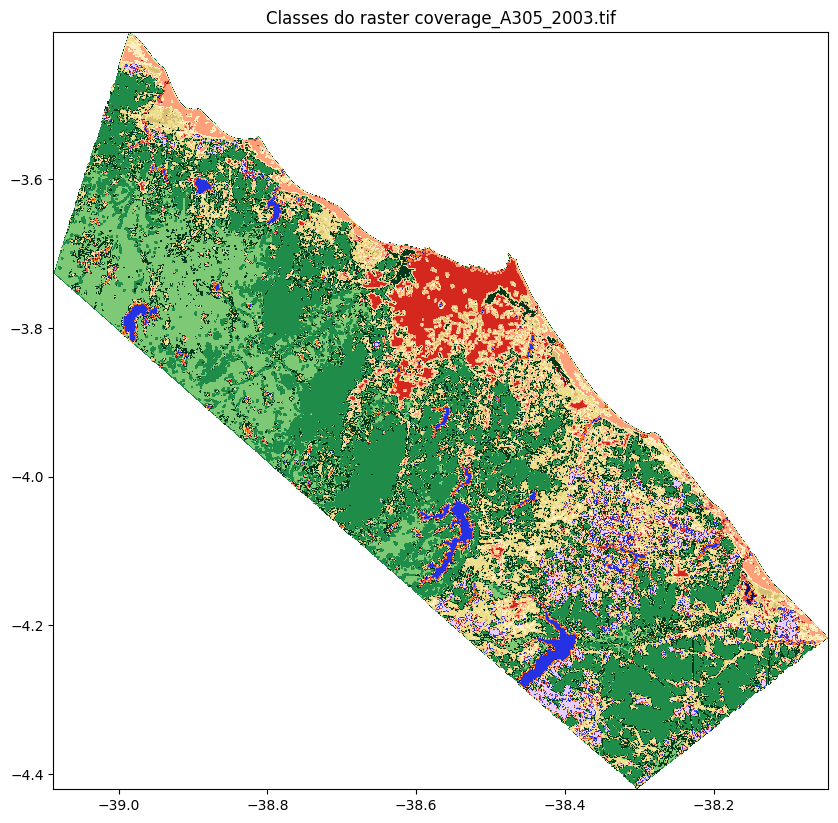

In [20]:
output_tif_path = '../dados/raster_tiff_caating/2003/coverage_A305_2003.tif'
plot_tiff_with_classes(output_tif_path)

In [21]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# Exibir as classificações e contagens
print("Contagem de superpixels por classe (ordenado):", sorted_class_counts)

Contagem de superpixels por classe (ordenado): {31: 2574, 32: 4683, 5: 24970, 41: 34098, 25: 47489, 12: 66877, 15: 120126, 23: 140382, 48: 149318, 33: 253628, 24: 451289, 21: 884053, 4: 1389258, 3: 1874707, 0: 9162207}


## Série temporal das estações

In [22]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['id_estacao','data', 'temperatura_max', 'temperatura_min', 'ano']]
temperaturas.head()

,id_estacao,data,temperatura_max,temperatura_min,ano
0,A305,2003-06-09,30.770016,31.062140,2003
1,A305,2003-06-24,30.765882,31.041971,2003
2,A305,2003-06-26,30.936176,30.991970,2003
3,A305,2003-06-29,30.956425,30.993690,2003
4,A305,2003-06-29,30.956425,30.993690,2003


In [23]:
temperaturas['id_estacao'].unique()

array(['A305', 'A306', 'A307', 'A308', 'A408', 'A412', 'A310', 'A309',
       'A313', 'A526', 'A539', 'A543', 'A314', 'A315', 'A316', 'A317',
       'A318', 'A319', 'A321', 'A322', 'A323', 'A324', 'A325', 'A327',
       'A329', 'A330', 'A331', 'A332', 'A333', 'A334', 'A336', 'A337',
       'A339', 'A340', 'A413', 'A415', 'A416', 'A417', 'A418', 'A419',
       'A420', 'A423', 'A424', 'A425', 'A426', 'A428', 'A429', 'A430',
       'A432', 'A433', 'A435', 'A436', 'A439', 'A440', 'A441', 'A442',
       'A443', 'A342', 'A349', 'A343', 'A328', 'A345', 'A347', 'A348',
       'A350', 'A351', 'A354', 'A358', 'A359', 'A360', 'A365', 'A366',
       'A367', 'A448', 'A450', 'A559', 'A563', 'A449', 'A454', 'A451',
       'A453', 'A370', 'A371', 'A372', 'A373', 'A368', 'A369', 'A458'],
      dtype=object)

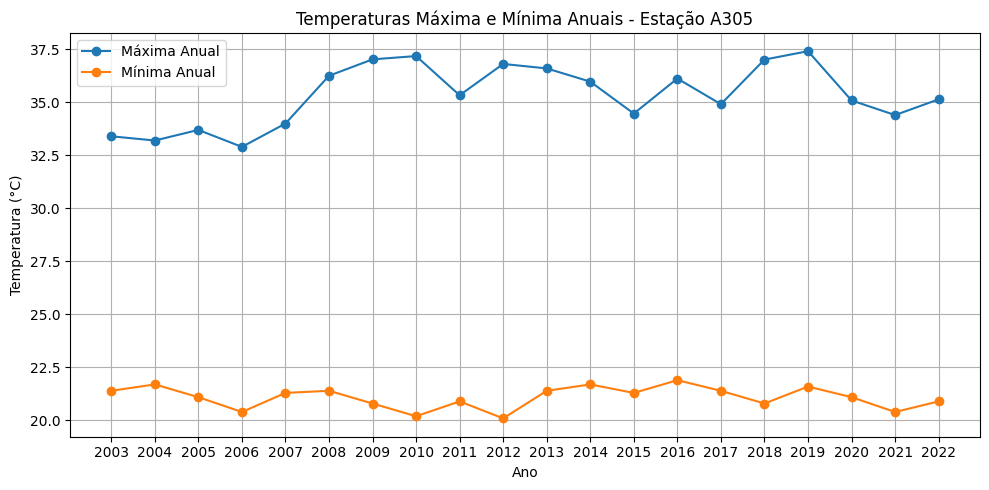

In [27]:
# Filtrar os dados apenas para a estação A305
dados_A305 = temperaturas[temperaturas['id_estacao'] == 'A305']

# Agrupar por ano e calcular a temperatura máxima e mínima anual
temperatura_anual = dados_A305.groupby('ano').agg(
    temperatura_max=('temperatura_max', 'max'),
    temperatura_min=('temperatura_min', 'min')
).reset_index()

# Plotar a série temporal anual
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima Anual', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima Anual', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais - Estação A305')
plt.xticks(range(temperatura_anual['ano'].min(), temperatura_anual['ano'].max() + 1))  # Define os ticks do eixo x para cada ano
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## Série temporal da vegetação na região de cada estação

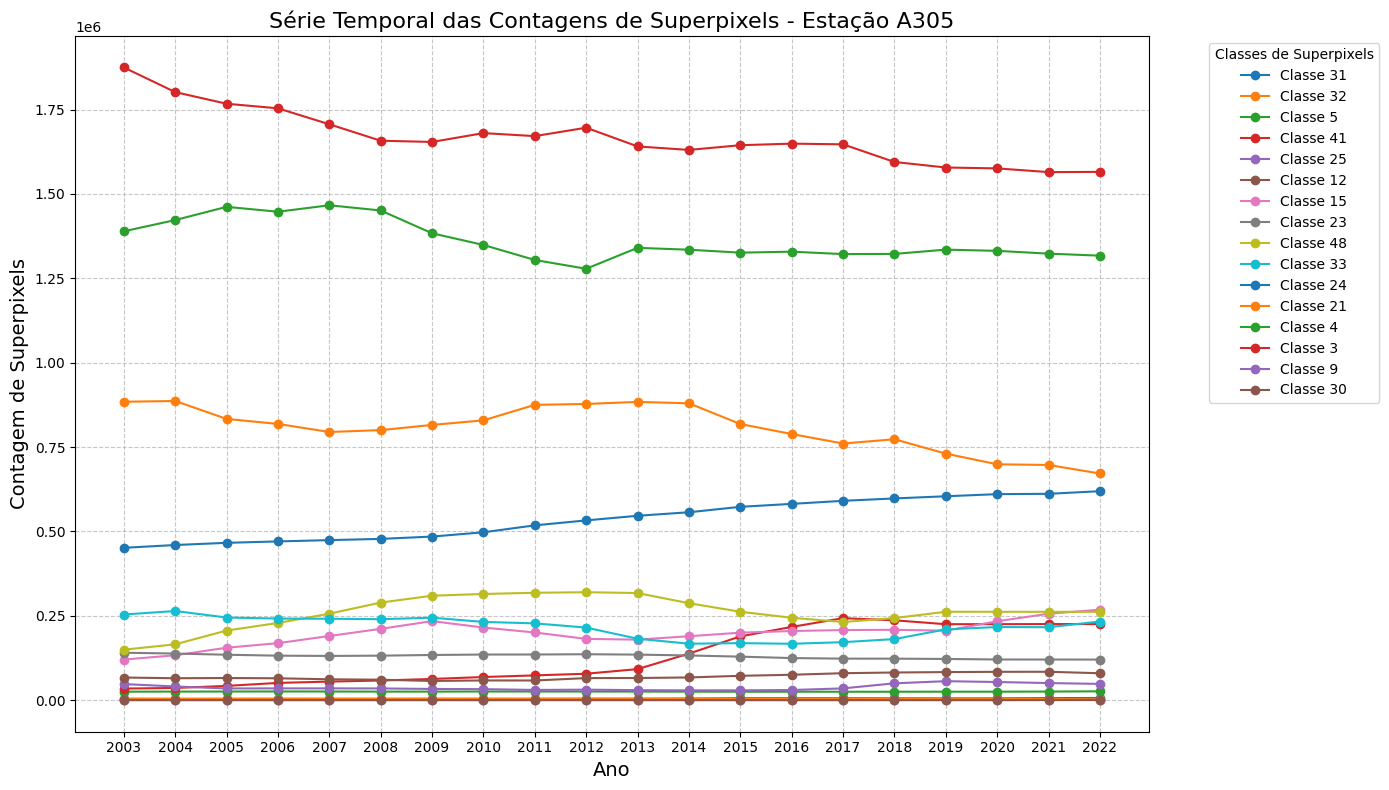

In [32]:
def plot_time_series(df_time_series, estacao_id):
    """
    Plotar a série temporal de contagem de superpixels por classe.

    Args:
    df_time_series (pd.DataFrame): DataFrame contendo a série temporal.
    estacao_id (str): ID da estação para o título do gráfico.
    """

    plt.figure(figsize=(14, 8))
    
    # Plotar cada classe de superpixel
    for class_id in df_time_series.columns:
        plt.plot(df_time_series.index, df_time_series[class_id], marker='o', label=f'Classe {class_id}')
    
    # Adicionar título e rótulos
    plt.title(f'Série Temporal das Contagens de Superpixels - Estação {estacao_id}', fontsize=16)
    plt.xlabel('Ano', fontsize=14)
    plt.ylabel('Contagem de Superpixels', fontsize=14)
    
    # Definir os ticks do eixo x para mostrar apenas anos inteiros
    plt.xticks(df_time_series.index, [str(int(year)) for year in df_time_series.index])
    
    # Adicionar uma grade
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adicionar a legenda fora do gráfico
    plt.legend(title='Classes de Superpixels', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Ajustar layout para evitar corte das legendas
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()

def create_time_series(output_base_dir, estacao_id, start_year, end_year):
    """
    Criar uma série temporal de contagem de superpixels por classe para uma estação específica,
    removendo IDs de classe com valor zero.

    Args:
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes foram salvos.
    estacao_id (str): ID da estação para criar a série temporal.
    start_year (int): Ano inicial da série temporal.
    end_year (int): Ano final da série temporal.

    Returns:
    pd.DataFrame: DataFrame contendo a série temporal.
    """

    # Criar um DataFrame para armazenar as contagens por ano
    time_series_data = {}

    for year in range(start_year, end_year + 1):
        tiff_path = os.path.join(output_base_dir, str(year), f'coverage_{estacao_id}_{year}.tif')

        if os.path.exists(tiff_path):
            sorted_class_counts = extract_classification_info(tiff_path)
            # Remover a entrada com ID de classe 0, se existir
            if 0 in sorted_class_counts:
                del sorted_class_counts[0]
            time_series_data[year] = sorted_class_counts
        else:
            print(f"Arquivo {tiff_path} não encontrado.")

    # Converter o dicionário em DataFrame
    df_time_series = pd.DataFrame(time_series_data).T.fillna(0)

    return df_time_series

# Definir parâmetros
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2022

# Criar a série temporal
df_time_series = create_time_series(output_base_dir, estacao_id, start_year, end_year)
plot_time_series(df_time_series, estacao_id)

## Montagem do dataset para cada estação

In [52]:
def calcular_media_temperatura(dados, estacao_id):
    """
    Calcula a média anual das temperaturas máximas e mínimas para uma estação específica.

    Args:
    dados (pd.DataFrame): DataFrame contendo as colunas ['id_estacao', 'data', 'temperatura_max', 'temperatura_min', 'ano'].
    estacao_id (str): ID da estação para filtrar os dados.

    Returns:
    pd.DataFrame: DataFrame com a média anual das temperaturas.
    """
    # Filtrar os dados para a estação específica
    dados_estacao = dados[dados['id_estacao'] == estacao_id]

    # Agrupar por ano e calcular a média das temperaturas máxima e mínima
    temperatura_anual = dados_estacao.groupby('ano').agg(
        temperatura_max_median=('temperatura_max', 'median'),
        temperatura_min_median=('temperatura_min', 'median')
    ).reset_index()

    return temperatura_anual

def combinar_datasets(temperatura_anual, df_time_series):
    """
    Combina a média anual das temperaturas com a série temporal de contagem de superpixels.

    Args:
    temperatura_anual (pd.DataFrame): DataFrame com a média anual das temperaturas.
    df_time_series (pd.DataFrame): DataFrame contendo a série temporal de contagem de superpixels.

    Returns:
    pd.DataFrame: DataFrame combinado com as temperaturas e a contagem de superpixels por ano.
    """
    # Mesclar os dois DataFrames usando o ano como chave
    dataset_combinado = pd.merge(temperatura_anual, df_time_series, left_on='ano', right_index=True, how='inner')
    
    return dataset_combinado

# Função para criar o dataset completo para uma estação
def criar_dataset_completo(dados, output_base_dir, estacao_id, start_year, end_year):
    """
    Cria um dataset completo combinando as médias de temperatura e a contagem de superpixels.

    Args:
    dados (pd.DataFrame): DataFrame contendo as colunas ['id_estacao', 'data', 'temperatura_max', 'temperatura_min', 'ano'].
    output_base_dir (str): Diretório base onde os GeoTIFFs resultantes foram salvos.
    estacao_id (str): ID da estação para criar o dataset.
    start_year (int): Ano inicial da série temporal.
    end_year (int): Ano final da série temporal.

    Returns:
    pd.DataFrame: DataFrame completo com as temperaturas e a contagem de superpixels por ano.
    """
    # Calcular a média anual das temperaturas
    temperatura_anual = calcular_media_temperatura(dados, estacao_id)

    # Criar a série temporal de superpixels
    df_time_series = create_time_series(output_base_dir, estacao_id, start_year, end_year)

    # Combinar os datasets
    dataset_completo = combinar_datasets(temperatura_anual, df_time_series)

    return dataset_completo

In [53]:
output_base_dir = '../dados/raster_tiff_caating'
estacao_id = 'A305'
start_year = 2003
end_year = 2022

# DataFrame inicial com os dados de temperatura
dados_A305 = temperaturas[temperaturas['id_estacao'] == estacao_id]

# Criar o dataset completo para a estação A305
dataset_completo_A305 = criar_dataset_completo(dados_A305, output_base_dir, estacao_id, start_year, end_year)

In [58]:
dataset_completo_A305.head()

,ano,temperatura_max_median,temperatura_min_median,31,32,5,41,25,12,15,23,48,33,24,21,4,3,9,30
0,2003,28.900000,27.500000,2574.0,4683.0,24970.0,34098.0,47489.0,66877.0,120126.0,140382.0,149318.0,253628.0,451289.0,884053.0,1389258.0,1874707.0,0.0,0.0
1,2004,28.100000,26.900000,2761.0,4410.0,25162.0,35944.0,40349.0,64771.0,132801.0,137925.0,165220.0,263979.0,459531.0,886343.0,1422501.0,1801735.0,0.0,0.0
2,2005,27.700000,26.400000,3344.0,4303.0,25392.0,42089.0,34459.0,65402.0,155191.0,134406.0,206048.0,244677.0,466019.0,833253.0,1461676.0,1767177.0,0.0,0.0
3,2006,31.572132,26.477482,3677.0,4081.0,25559.0,50899.0,34696.0,64630.0,168667.0,131636.0,228522.0,241594.0,470223.0,818379.0,1447196.0,1753663.0,0.0,0.0
4,2007,27.500000,26.600000,3748.0,3909.0,25426.0,54823.0,34702.0,61626.0,189931.0,130868.0,256069.0,241064.0,474057.0,794502.0,1466322.0,1706385.0,0.0,0.0


## Aplicação do Filtro de Sobel nas Séries Temporais
Vamos aplicar o filtro de Sobel para identificar mudanças abruptas nas séries temporais de temperatura e vegetação.

In [ ]:
from scipy.ndimage import sobel

# Aplicar o filtro de Sobel nas séries temporais
sobel_temp_max = sobel(dataset_completo_A305['temperatura_max_median'], mode='constant')
sobel_temp_min = sobel(dataset_completo_A305['temperatura_min_median'], mode='constant')
sobel_vegetation = dataset_completo_A305.drop(columns=['ano', 'temperatura_max_median', 'temperatura_min_median']).apply(lambda x: sobel(x, mode='constant'))

# Adicionar ao DataFrame para visualização
dataset_completo_A305['Sobel_Temperature_Max'] = sobel_temp_max
dataset_completo_A305['Sobel_Temperature_Min'] = sobel_temp_min
dataset_completo_A305 = pd.concat([dataset_completo_A305, sobel_vegetation.add_prefix('Sobel_')], axis=1)

### Filtro de Sobel

O filtro de Sobel é um operador de detecção de bordas usado em processamento de imagens, mas também pode ser aplicado a séries temporais para detectar mudanças ou transições bruscas em dados. Ele calcula a derivada aproximada da função em cada ponto, destacando regiões onde a variação é mais intensa, o que corresponde a bordas em imagens ou a mudanças abruptas em séries temporais.

- **`from scipy.ndimage import sobel`**: Importa a função `sobel` da biblioteca `scipy.ndimage`, que aplica o filtro de Sobel a arrays N-dimensional.

- **`sobel(dataset_completo_A305['temperatura_max_median'], mode='constant')`**: Aplica o filtro de Sobel à série temporal `temperatura_max_median` (temperatura máxima mediana). O parâmetro `mode='constant'` define como as bordas da série temporal devem ser tratadas. Neste caso, os valores fora dos limites são considerados constantes.
- **`sobel_temp_max`**: Contém os resultados do filtro de Sobel aplicado à temperatura máxima, destacando mudanças bruscas ou transições na série temporal.
- **`sobel_temp_min`**: Similar ao `sobel_temp_max`, mas aplicado à temperatura mínima mediana.

- **`dataset_completo_A305.drop(columns=['ano', 'temperatura_max_median', 'temperatura_min_median'])`**: Remove as colunas `ano`, `temperatura_max_median`, e `temperatura_min_median` do dataset, focando nas colunas relacionadas à vegetação.
- **`apply(lambda x: sobel(x, mode='constant'))`**: Aplica o filtro de Sobel a cada coluna restante (que são as variáveis de vegetação), uma de cada vez. O resultado é uma nova série onde as transições ou mudanças bruscas em cada variável de vegetação são destacadas.
- **`sobel_vegetation`**: Armazena o resultado do filtro de Sobel aplicado às variáveis de vegetação.

- **`dataset_completo_A305['Sobel_Temperature_Max'] = sobel_temp_max`**: Cria uma nova coluna no dataset original chamada `Sobel_Temperature_Max`, que armazena os resultados do filtro de Sobel aplicado à temperatura máxima.
- **`dataset_completo_A305['Sobel_Temperature_Min'] = sobel_temp_min`**: Similar à linha anterior, mas para a temperatura mínima.

- **`sobel_vegetation.add_prefix('Sobel_')`**: Adiciona o prefixo `Sobel_` aos nomes das colunas resultantes do filtro aplicado às variáveis de vegetação.
- **`pd.concat([...], axis=1)`**: Concatena o dataset original `dataset_completo_A305` com as novas colunas `Sobel_` derivadas das variáveis de vegetação, colocando-as lado a lado (`axis=1`).

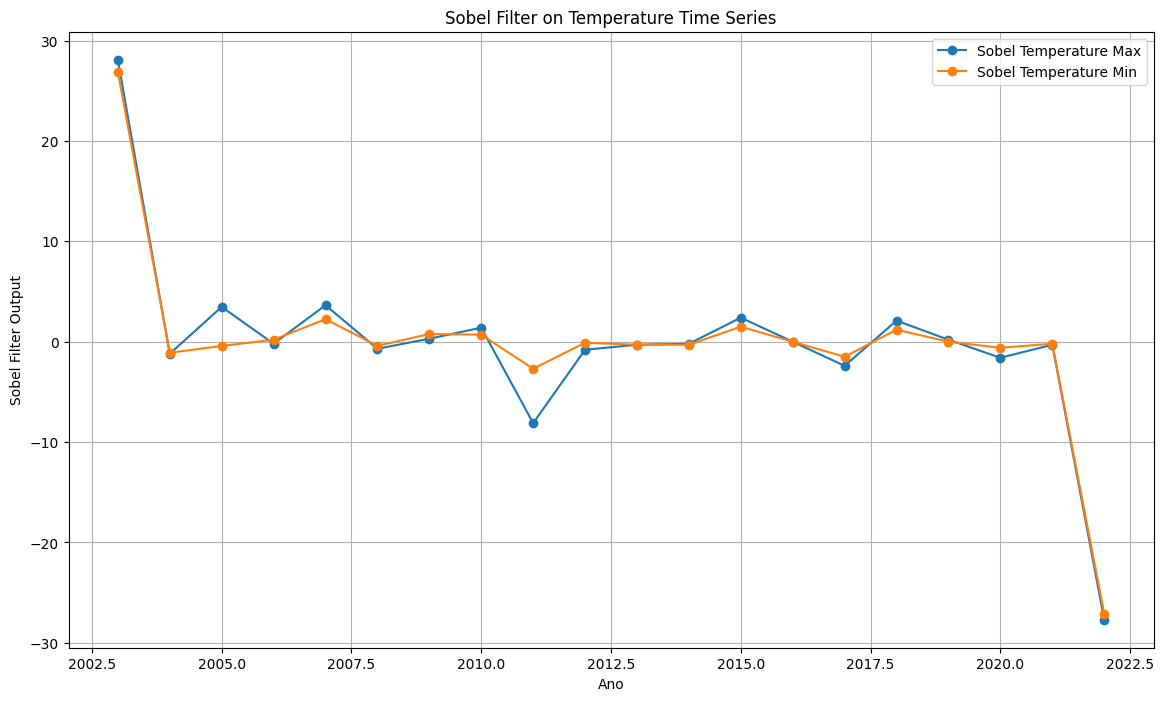

In [69]:
# Plotar os resultados para a temperatura
plt.figure(figsize=(14, 8))
plt.plot(dataset_completo_A305['ano'], dataset_completo_A305['Sobel_Temperature_Max'], label='Sobel Temperature Max', marker='o')
plt.plot(dataset_completo_A305['ano'], dataset_completo_A305['Sobel_Temperature_Min'], label='Sobel Temperature Min', marker='o')
plt.xlabel('Ano')
plt.ylabel('Sobel Filter Output')
plt.title('Sobel Filter on Temperature Time Series')
plt.legend()
plt.grid(True)
plt.show()

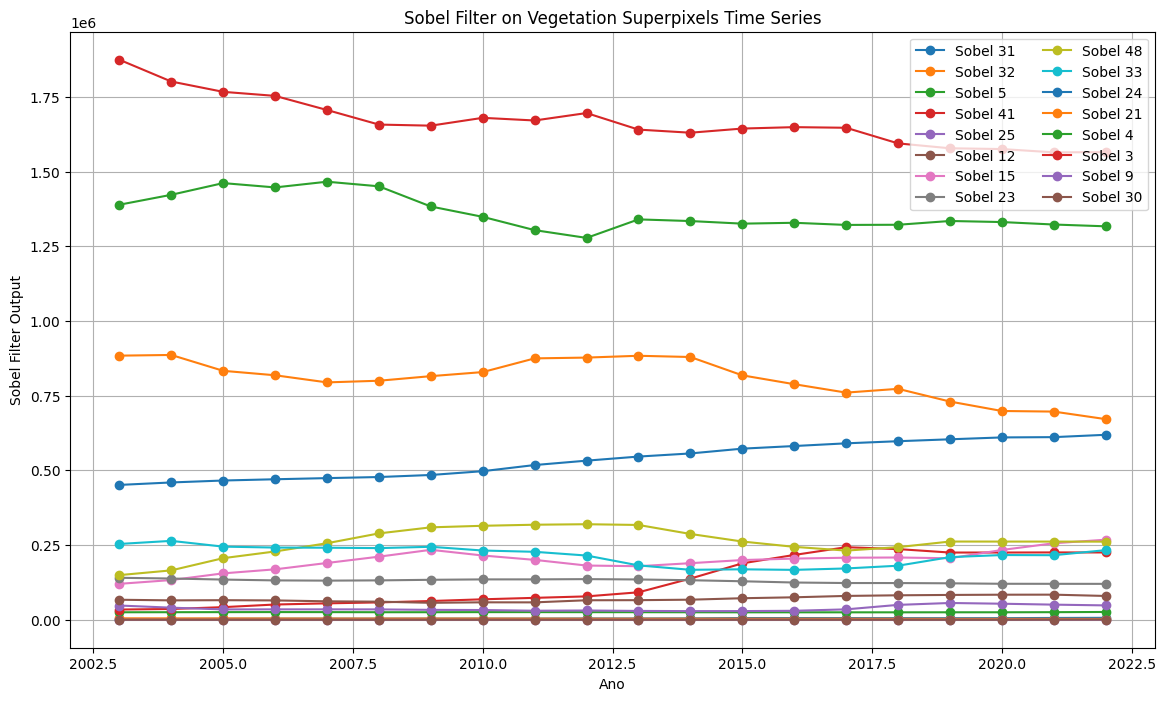

In [64]:
# Plotar os resultados para as classes de vegetação
plt.figure(figsize=(14, 8))
for col in sobel_vegetation.columns:
    plt.plot(dataset_completo_A305['ano'], dataset_completo_A305[col], marker='o', label=f'Sobel {col}')
plt.xlabel('Ano')
plt.ylabel('Sobel Filter Output')
plt.title('Sobel Filter on Vegetation Superpixels Time Series')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.show()

## Análise da Correlação Usando a Transformada de Fourier
Agora, vamos aplicar a Transformada de Fourier para analisar as frequências dominantes e a correlação de fase entre as séries temporais de temperatura e vegetação.

In [ ]:
from numpy.fft import fft, ifft

# Função para calcular a Transformada de Fourier e a correlação de fase
def phase_correlation(series1, series2):
    f1 = fft(series1)
    f2 = fft(series2)
    cross_power_spectrum = (f1 * np.conjugate(f2)) / np.abs(f1 * np.conjugate(f2))
    correlation = ifft(cross_power_spectrum)
    return np.abs(correlation)

# Aplicar a Transformada de Fourier e calcular a correlação de fase
correlation_max = {}
correlation_min = {}

for col in sobel_vegetation.columns:
    correlation_max[col] = phase_correlation(dataset_completo_A305['temperatura_max_median'], dataset_completo_A305[col])
    correlation_min[col] = phase_correlation(dataset_completo_A305['temperatura_min_median'], dataset_completo_A305[col])

### Transformada de Fourier

A **Transformada de Fourier (FFT - Fast Fourier Transform)** é uma técnica matemática que transforma uma função de tempo (ou espaço) em uma função de frequência. No contexto de séries temporais, a FFT é usada para decompor uma série de dados em seus componentes de frequência, revelando as frequências que compõem a série.

- **`from numpy.fft import fft, ifft`**: Importa as funções `fft` (Fast Fourier Transform) e `ifft` (Inverse Fast Fourier Transform) da biblioteca NumPy. `fft` transforma os dados do domínio do tempo para o domínio da frequência, e `ifft` faz o processo inverso, retornando ao domínio do tempo.

- **`def phase_correlation(series1, series2):`**: Define uma função chamada `phase_correlation` que calcula a correlação de fase entre duas séries temporais (`series1` e `series2`).

- **`f1 = fft(series1)`**: Aplica a FFT na primeira série temporal (`series1`), transformando-a do domínio do tempo para o domínio da frequência. `f1` é a representação da série em termos de suas frequências constituintes.

- **`f2 = fft(series2)`**: Similar ao `f1`, aplica a FFT na segunda série temporal (`series2`).

- **`cross_power_spectrum = (f1 * np.conjugate(f2)) / np.abs(f1 * np.conjugate(f2))`**: 
    - **`f1 * np.conjugate(f2)`**: Calcula o espectro de potência cruzado das duas séries temporais, que é uma medida de como as frequências de `f1` e `f2` estão relacionadas.
    - **`np.abs(f1 * np.conjugate(f2))`**: Normaliza o espectro de potência cruzado para garantir que o resultado seja uma medida de fase pura, removendo a magnitude (amplitude).
    - **`cross_power_spectrum`**: O espectro de potência cruzado normalizado, usado para calcular a correlação de fase.

- **`correlation = ifft(cross_power_spectrum)`**: Aplica a Transformada Inversa de Fourier (IFFT) ao espectro de potência cruzado, retornando ao domínio do tempo. O resultado é a correlação de fase entre as duas séries temporais.

- **`return np.abs(correlation)`**: Retorna o valor absoluto da correlação de fase, que é uma medida de quão alinhadas estão as séries temporais em termos de suas fases.

### Aplicar a Função em Colunas do Dataset

- **`correlation_max = {}`** e **`correlation_min = {}`**: Inicializam dois dicionários para armazenar as correlações de fase entre as séries temporais de temperatura máxima e mínima, respectivamente, e cada uma das colunas relacionadas à vegetação.

- **`for col in sobel_vegetation.columns:`**: Itera por todas as colunas do `sobel_vegetation`, que contém as séries temporais transformadas pelo filtro de Sobel.

- **`correlation_max[col] = phase_correlation(dataset_completo_A305['temperatura_max_median'], dataset_completo_A305[col])`**: Calcula a correlação de fase entre a série temporal de temperatura máxima (`temperatura_max_median`) e a série da coluna atual (`col`). O resultado é armazenado no dicionário `correlation_max` sob a chave correspondente ao nome da coluna.

- **`correlation_min[col] = phase_correlation(dataset_completo_A305['temperatura_min_median'], dataset_completo_A305[col])`**: Faz o mesmo que a linha anterior, mas para a temperatura mínima (`temperatura_min_median`). O resultado é armazenado no dicionário `correlation_min`.

In [68]:
def average_phase_correlation(correlation_dict):
    """
    Calcula a média da correlação de fase para cada série temporal.

    Args:
    correlation_dict (dict): Dicionário com séries temporais de correlação de fase.

    Returns:
    pd.Series: Série com a média da correlação de fase para cada classe.
    """
    avg_correlation = {}
    for key, value in correlation_dict.items():
        avg_correlation[key] = np.mean(value)

    return pd.Series(avg_correlation)

# Calcular a média da correlação de fase para temperatura máxima e mínima
avg_corr_max = average_phase_correlation(correlation_max)
avg_corr_min = average_phase_correlation(correlation_min)

# Exibir os resultados
print("Média da Correlação de Fase com Temperatura Máxima:")
print(avg_corr_max)

print("\nMédia da Correlação de Fase com Temperatura Mínima:")
print(avg_corr_min)

Média da Correlação de Fase com Temperatura Máxima:
31    0.167355
32    0.177787
5     0.185922
41    0.158603
25    0.191284
12    0.172961
15    0.169080
23    0.174883
48    0.179043
33    0.182045
24    0.170147
21    0.177041
4     0.163146
3     0.168393
9     0.181682
30    0.175670
dtype: float64

Média da Correlação de Fase com Temperatura Mínima:
31    0.181180
32    0.172643
5     0.195139
41    0.180852
25    0.192600
12    0.181823
15    0.182210
23    0.171591
48    0.186207
33    0.174817
24    0.184207
21    0.177780
4     0.174612
3     0.168119
9     0.166749
30    0.165167
dtype: float64


**Classes Relacionadas à Agricultura:**
   - **ID 25 - Outras áreas não vegetadas (Non Vegetated Area):** Teve uma correlação média relativamente alta tanto com a temperatura máxima (`0.191284`) quanto com a mínima (`0.192600`). Isso sugere que as mudanças nessas áreas podem ser altamente influenciadas por variações de temperatura, talvez devido à falta de cobertura vegetal que poderia moderar as variações térmicas.
   - **ID 15 - Pastagens:** Teve correlação moderada com ambas as temperaturas, o que faz sentido, já que as pastagens podem ser altamente sensíveis às mudanças na temperatura, especialmente em termos de crescimento e saúde das plantas.

**Classes Naturais:**
   - **ID 3 - Formações Florestais:** Esta classe apresenta uma correlação média menor em relação às temperaturas. Isso pode indicar que as florestas são menos suscetíveis a variações de temperatura em termos de mudanças detectáveis na série temporal de superpixels.
   - **ID 12 - Grasslands:** Apresenta uma correlação moderada, o que é esperado, pois os pastos naturais podem ser sensíveis à seca e ao calor.

**Áreas Não Vegetadas:**
   - **ID 30 - Mineração:** A correlação mais baixa com a temperatura mínima sugere que as áreas de mineração, sendo artificialmente alteradas, podem não responder de forma previsível às variações de temperatura.

**Água e Áreas Húmidas:**
   - **ID 33 - Rios, lagos e oceanos:** Esses corpos d'água apresentam uma correlação moderada, sugerindo que, embora as temperaturas possam influenciar o comportamento dos corpos d'água, eles também são afetados por outros fatores, como precipitação e gestão hídrica.